# Trabajo práctico 2: Críticas cinematográficas
**Grupo 10**

*   De Matías Pose, Ignacio
*   Duzac, Juan Martín
*   Pico, Carolina
*   Bigey, Pierre


# Librerias

In [ ]:
#Drive para montar los csv
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
#Manipulacion de datos y funciones matemáticas
import pandas as pd
import numpy as np

#Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt

#Modelo Lineal
from sklearn.linear_model import LinearRegression

#Metricas para evaluar modelos
from sklearn import metrics

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.impute import SimpleImputer

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer

import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline

#Redes neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

#Ensamble stacking
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier

#Exploración inicial del dataset

In [ ]:
df_criticas_train_original = pd.read_csv("/content/drive/MyDrive/datasets/Tp2OrgDatos/criticas_train.csv")
df_criticas_test_original = pd.read_csv("/content/drive/MyDrive/datasets/Tp2OrgDatos/criticas_test.csv")


In [ ]:
df_criticas_train_copy = df_criticas_train_original.copy()
df_criticas_test_copy = df_criticas_test_original.copy()

In [ ]:
df_criticas_train_copy.columns

Index(['ID', 'review_es', 'sentimiento'], dtype='object')

## Primera mirada del dataset
Observamos las primeras filas del dataset para tener idea de como está compuesto

In [ ]:
df_criticas_train_copy.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [ ]:
df_criticas_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Buscamos a ver si hay filas repetidas

In [ ]:
df_criticas_train_original[df_criticas_train_original.duplicated(keep=False)]

,ID,review_es,sentimiento


Buscamos valores nulos

In [ ]:
df_criticas_train_copy.isna().sum()

ID             0
review_es      0
sentimiento    0
dtype: int64

# Preprocesamiento

### Split de la data

In [ ]:
from nltk import FreqDist
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

nltk.download('words')


# Obtener todas las palabras del dataset
all_words = ' '.join(df_criticas_train_copy['review_es']).split()

# Calcular la frecuencia de las palabras
freq_dist = FreqDist(all_words)

# Obtener las palabras más frecuentes y las palabras con menos de 3 letras
most_common_words = set([word for word, freq in freq_dist.most_common(10)])
short_words = set([word for word in freq_dist if len(word) < 3])

# Definir la función para eliminar las palabras más frecuentes y las palabras con menos de 3 letras
def remove_common_and_short_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in most_common_words and word not in short_words]
    return ' '.join(filtered_words)

# Aplicar la función al dataframe
df_criticas_train_copy['review_es'] = df_criticas_train_copy['review_es'].apply(remove_common_and_short_words)

# Eliminar palabras en inglés y convertir texto a minúsculas
stop_words = set(stopwords.words('spanish'))
df_criticas_train_copy['review_es'] = df_criticas_train_copy['review_es'].apply(lambda x: ' '.join([word.lower() for word in str(x).split() if word.lower() not in stop_words]))


vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(df_criticas_train_copy['review_es'])
y_train = df_criticas_train_copy['sentimiento']

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.30, random_state=25, stratify=y_train)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Custom LabelEncoder for pipelines

In [ ]:
# Custom transformer to apply LabelEncoder to y_train
class TargetEncoder:
    def __init__(self):
        self.encoder = LabelEncoder()

    def fit(self, x=0, y=0):
        self.encoder.fit(y)
        return self

    def transform(self, x=0, y=0):
        return self.encoder.transform(y)

    def fit_transform(self, x, y=0):
        return self.encoder.fit_transform(y)

#Bayes Naive

##Modelo

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Definir los valores de los hiperparámetros a probar
param_grid = {
    'alpha': [0.438, 0.44, 0.442, 0.446, 0.448, 0.45]
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1')

# Ejecutar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search.fit(x_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

Mejores hiperparámetros: {'alpha': 0.438}


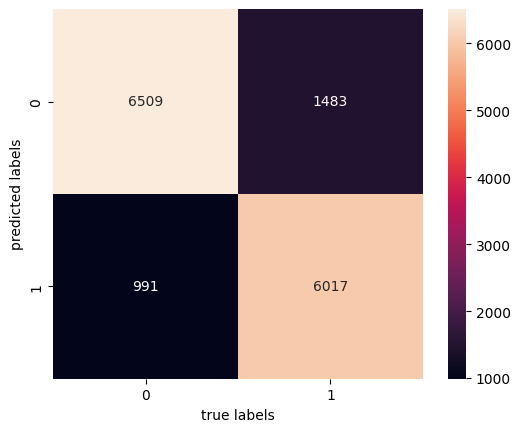

F1-Score: 0.829473393989523
Precision-Score: 0.8585901826484018
Recall-Score: 0.8022666666666667


In [ ]:
# Obtener el mejor modelo encontrado durante la búsqueda en cuadrícula
best_model = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de validación
y_pred = best_model.predict(x_test)

matriz=confusion_matrix(y_test, y_pred)
sns.heatmap(matriz.T, square=True, annot=True, fmt="d")
plt.xlabel("true labels")
plt.ylabel("predicted labels")
plt.show()

#Validation metrics
print('F1-Score: {}'.format(f1_score(y_test, y_pred, pos_label='positivo')))
print('Precision-Score: {}'.format(precision_score(y_test, y_pred, pos_label='positivo')))
print('Recall-Score: {}'.format(recall_score(y_test, y_pred, pos_label='positivo')))

In [ ]:
print (y_pred)

##Submission

In [ ]:
df_criticas_test_x = vectorizer.transform(df_criticas_test_copy['review_es'])


In [ ]:
prediction_BN=best_model.predict(df_criticas_test_x)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(['negativo', 'positivo'])
y_pred_BN = label_encoder.inverse_transform(prediction_BN)
print(y_pred_BN)

['negativo' 'negativo' 'negativo' ... 'negativo' 'negativo' 'negativo']


In [ ]:
df_submission = pd.DataFrame({"ID":df_criticas_test_copy['ID'], "sentimiento" : y_pred_BN.flatten()})
print(df_submission.shape)
print(df_criticas_test_copy.shape)
df_submission.head()

(8599, 2)
(8599, 2)


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo


In [ ]:
df_submission.to_csv("submission_bayes_naive.csv",index=False)

dio 0,70 aprox. se debe poder mejorar

# Random Forest

Grid Sreach

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(df_criticas_train_copy['review_es'])
y_train = df_criticas_train_copy['sentimiento']

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.30, random_state=25, stratify=y_train)

NameError: ignored

In [ ]:
# Definir los valores de los hiperparámetros a probar
param_grid = {
    'n_estimators': [150],
    'max_depth': [18, 20],
    'min_samples_split': [6],
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=4, scoring='f1')

# Ejecutar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search.fit(x_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/l

Mejores hiperparámetros: {'max_depth': 18, 'min_samples_split': 6, 'n_estimators': 150}


Mejor clasificador y métricas

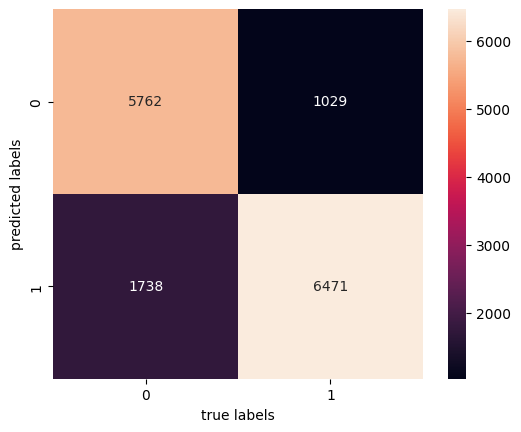

F1-Score: 0.8238589343688331
Precision-Score: 0.7882811548300646
Recall-Score: 0.8628


In [ ]:
# Obtener el mejor modelo encontrado durante la búsqueda en cuadrícula
best_model = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de validación
y_pred = best_model.predict(x_test)

matriz=confusion_matrix(y_test, y_pred)
sns.heatmap(matriz.T, square=True, annot=True, fmt="d")
plt.xlabel("true labels")
plt.ylabel("predicted labels")
plt.show()

#Validation metrics
print('F1-Score: {}'.format(f1_score(y_test, y_pred, pos_label='positivo')))
print('Precision-Score: {}'.format(precision_score(y_test, y_pred, pos_label='positivo')))
print('Recall-Score: {}'.format(recall_score(y_test, y_pred, pos_label='positivo')))

##Submission

In [ ]:
df_criticas_test_x = df_criticas_test_copy['review_es']

In [ ]:
df_criticas_test_x_vectorized = vectorizer.transform(df_criticas_test_x)
prediction_RF=best_model.predict(df_criticas_test_x_vectorized)

In [ ]:
print (prediction_RF)


['negativo' 'negativo' 'negativo' ... 'positivo' 'negativo' 'negativo']


In [ ]:
df_submission = pd.DataFrame({"ID":df_criticas_test_copy['ID'], "sentimiento" : prediction_RF.flatten()})
print(df_submission.shape)
print(df_criticas_test_copy.shape)
df_submission.head()

(8599, 2)
(8599, 2)


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo


In [ ]:
df_submission.to_csv("submission_random_forest.csv",index=False)

#XGBoost

Grid search

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(df_criticas_train_copy['review_es'])
y_train = LabelEncoder().fit_transform(df_criticas_train_copy['sentimiento'])

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.30, random_state=25, stratify=y_train)

# Define the parameters of the XGBoost classifier and the range of values to search
params = {'learning_rate': [0.1],
          'max_depth': [13],
          'min_child_weight': [1],
          'gamma': [0.08],
          'subsample': [1],
          'colsample_bytree': [0.5],
          'n_estimators': [110]}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=0)
# Perform a grid search for hyperparameter tuning
grid_search_XGB = GridSearchCV(estimator=xgb_model, param_grid=params, cv=5, scoring='f1')

#Busco los hiperparamtros que optimizan F1 Score
#grid_search_XGB.fit(x_train,y_train)
grid_search_XGB.fit(x_train,y_train)

# Print the best hyperparameters and their corresponding F1 score
print(grid_search_XGB.best_params_)
print(grid_search_XGB.best_score_)

{'colsample_bytree': 0.5, 'gamma': 0.08, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 1, 'n_estimators': 110, 'subsample': 1}
0.837235122194764


Mejor clasificador y métricas

In [ ]:
x_train
print(y_pred)

In [ ]:
# Obtener el mejor modelo encontrado durante grid search
best_model_XGB = grid_search_XGB.best_estimator_

# Evaluar el mejor modelo en el conjunto de validación
y_pred = best_model_XGB.predict(x_test)

matriz=confusion_matrix(y_test, y_pred)
sns.heatmap(matriz.T, square=True, annot=True, fmt="d")
plt.xlabel("true labels")
plt.ylabel("predicted labels")
plt.show()

#Validation metrics
print('F1-Score: {}'.format(f1_score(y_test, y_pred)))
print('Precision-Score: {}'.format(precision_score(y_test, y_pred)))
print('Recall-Score: {}'.format(recall_score(y_test, y_pred)))

##Submission

In [ ]:
df_criticas_test_copy

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


In [ ]:
df_criticas_test_x = vectorizer.transform(df_criticas_test_copy['review_es'])
#df_criticas_test_y = LabelEncoder().fit_transform(df_criticas_test_copy['sentimiento'])

In [ ]:
df_criticas_test_x

<8599x175853 sparse matrix of type '<class 'numpy.int64'>'
	with 1029120 stored elements in Compressed Sparse Row format>

In [ ]:
prediction_XGB=best_model_XGB.predict(df_criticas_test_x)

In [ ]:
print(prediction_XGB)

[0 0 0 ... 0 0 0]


Requerimos volver a transformar a 'negativo' y 'positivo' para el sumbit.

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(['negativo', 'positivo'])
y_pred_XGB = label_encoder.inverse_transform(prediction_XGB)
print(y_pred_XGB)

['negativo' 'negativo' 'negativo' ... 'negativo' 'negativo' 'negativo']


In [ ]:
df_submission = pd.DataFrame({"ID":df_criticas_test_copy['ID'], "sentimiento" : y_pred_XGB.flatten()})
print(df_submission.shape)
print(df_criticas_test_copy.shape)
df_submission.head()

(8599, 2)
(8599, 2)


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo


In [ ]:
df_submission.to_csv("submission_XGB.csv",index=False)

#Red neuronal

Preprocesamiento:

- vectorizamos los textos de x_train
- llevamos a 1 y 0 las categorias binarias 'positivo' y 'negativo'

In [ ]:
# Realizar el preprocesamiento y la vectorización
vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(df_criticas_train_copy['review_es'])
y_train = LabelEncoder().fit_transform(df_criticas_train_copy['sentimiento'])

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.30, random_state=25, stratify=y_train)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = Sequential()
model.add(Dense(64  , activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.18))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', patience=5)


# Compiling the model
model.compile(loss='bce',
              optimizer='adam',
              metrics=[f1_m])

# Sort the indices of the sparse tensors
x_train.sort_indices()
x_test.sort_indices()

# Fitting the model
history = model.fit(x_train,
                    y_train,
                    batch_size = 64,
                    validation_data =(x_test, y_test),
                    epochs = 600,
                    verbose = 0,
                    callbacks=[es])

Métricas

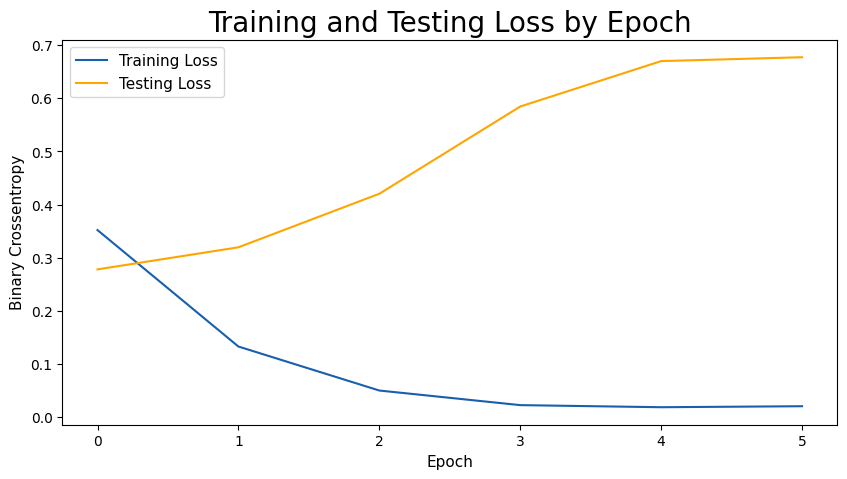

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Visualizing our training and testing loss by epoch
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11);

In [ ]:
# Scoring
train_score = model.evaluate(x_train,
                       y_train,
                       verbose=1)
test_score = model.evaluate(x_test,
                       y_test,
                       verbose=1)
labels = model.metrics_names

print('')
print(f'Training f1: {train_score[1]}')
print(f'Testing f1: {test_score[1]}')

469/469 [==============================] - 2s 3ms/step - loss: 0.6771 - f1_m: 0.8697

Training f1: 0.99858158826828
Testing f1: 0.8696755170822144


In [ ]:
# Making predictions
y_predic = (model.predict(x_test) > 0.5).astype("int32")

# Creating confusion matrix
cm = confusion_matrix(y_test, y_predic)

# putting the matrix a dataframe form
cm_df = pd.DataFrame(cm, index=['No cancelado', 'Cancelado'],
                 columns=['No cancelado', 'Cancelado'])

469/469 [==============================] - 2s 3ms/step


F1-Score: 0.8731185635067336
Precision-Score: 0.8646705020920502
Recall-Score: 0.8817333333333334


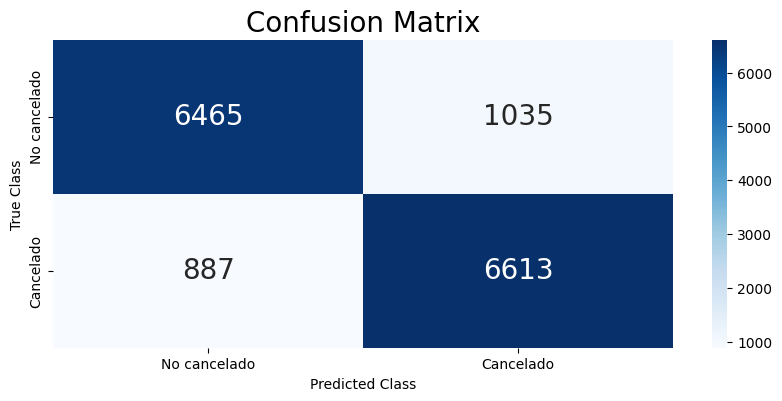

In [ ]:
# visualizing the confusion matrix
plt.figure(figsize=(10,4))

sns.heatmap(cm, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df.columns, yticklabels=cm_df.index, annot_kws={"size": 20})
plt.title("Confusion Matrix", size=20)
plt.xlabel('Predicted Class')
plt.ylabel('True Class');

#Validation metrics
print('F1-Score: {}'.format(f1_score(y_test, y_predic)))
print('Precision-Score: {}'.format(precision_score(y_test, y_predic)))
print('Recall-Score: {}'.format(recall_score(y_test, y_predic)))

##Submission

In [ ]:
df_criticas_test_copy

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


In [ ]:
df_criticas_test_x = vectorizer.transform(df_criticas_test_copy['review_es'])
#df_criticas_test_y = LabelEncoder().fit_transform(df_criticas_test_copy['sentimiento'])

In [ ]:
df_criticas_test_x

<8599x175853 sparse matrix of type '<class 'numpy.int64'>'
	with 1029120 stored elements in Compressed Sparse Row format>

In [ ]:
prediction_NN=(model.predict(df_criticas_test_x) > 0.5).astype("int32")

269/269 [==============================] - 1s 3ms/step


In [ ]:
print(prediction_NN.shape)

(8599, 1)


Requerimos volver a transformar a 'negativo' y 'positivo' para el sumbit.

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(['negativo', 'positivo'])
prediction_NN = label_encoder.inverse_transform(prediction_NN)
print(prediction_NN)

['negativo' 'positivo' 'negativo' ... 'positivo' 'negativo' 'negativo']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(prediction_NN.shape)

(8599,)


In [ ]:
df_submission = pd.DataFrame({"ID":df_criticas_test_copy['ID'], "sentimiento" : prediction_NN.flatten()})
print(df_submission.shape)
print(df_criticas_test_copy.shape)
df_submission.head()

(8599, 2)
(8599, 2)


,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,positivo
4,60004,negativo


In [ ]:
df_submission.to_csv("submission_NN.csv",index=False)

#Ensamble

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Realizar el preprocesamiento y la vectorización
from nltk import FreqDist
import pandas as pd

# Obtener todas las palabras del dataset
all_words = ' '.join(df_criticas_train_copy['review_es']).split()

# Calcular la frecuencia de las palabras
freq_dist = FreqDist(all_words)

# Obtener las palabras más frecuentes y las palabras con menos de 3 letras
most_common_words = set([word for word, freq in freq_dist.most_common(10)])
short_words = set([word for word in freq_dist if len(word) < 3])

# Definir la función para eliminar las palabras más frecuentes y las palabras con menos de 3 letras
def remove_common_and_short_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in most_common_words and word not in short_words]
    return ' '.join(filtered_words)

# Aplicar la función al dataframe
df_criticas_train_copy['review_es'] = df_criticas_train_copy['review_es'].apply(remove_common_and_short_words)
vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(df_criticas_train_copy['review_es'])
y_train = LabelEncoder().fit_transform(df_criticas_train_copy['sentimiento'])

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.30, random_state=25, stratify=y_train)

In [ ]:
#Meta Modelo
meta_model = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=13,
    min_child_weight=1,
    gamma=0.08,
    subsample=1,
    colsample_bytree=0.5,
    n_estimators=110
)

#Modelos Base
base_models = [('random_forest', RandomForestClassifier(n_estimators=100)),
               ('svm', SVC()),
               ('knn', KNeighborsClassifier(n_neighbors=5))]

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=3,
                                    verbose=2)

In [ ]:
stacking_model.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 23.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 69.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


StackingClassifier(cv=3,
                   estimators=[('random_forest', RandomForestClassifier()),
                               ('svm', SVC()),
                               ('knn', KNeighborsClassifier())],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=0.5,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None,
                                                 feature_types=No...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=13, max_leaves=None,
                                                 min_child_weight=1,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=110, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=None, ...),
                   passthrough=True, verbose=2)

Mejor clasificador y métricas

In [33]:
#Predicción con mejor estimador
y_pred=stacking_model.predict(x_test)

#Validation metrics
print('F1-Score: {}'.format(f1_score(y_test, y_pred)))
print('Precision-Score: {}'.format(precision_score(y_test, y_pred)))
print('Recall-Score: {}'.format(recall_score(y_test, y_pred)))

F1-Score: 0.8784188460770613
Precision-Score: 0.8768433638899961
Recall-Score: 0.88


Text(95.72222222222221, 0.5, 'True')

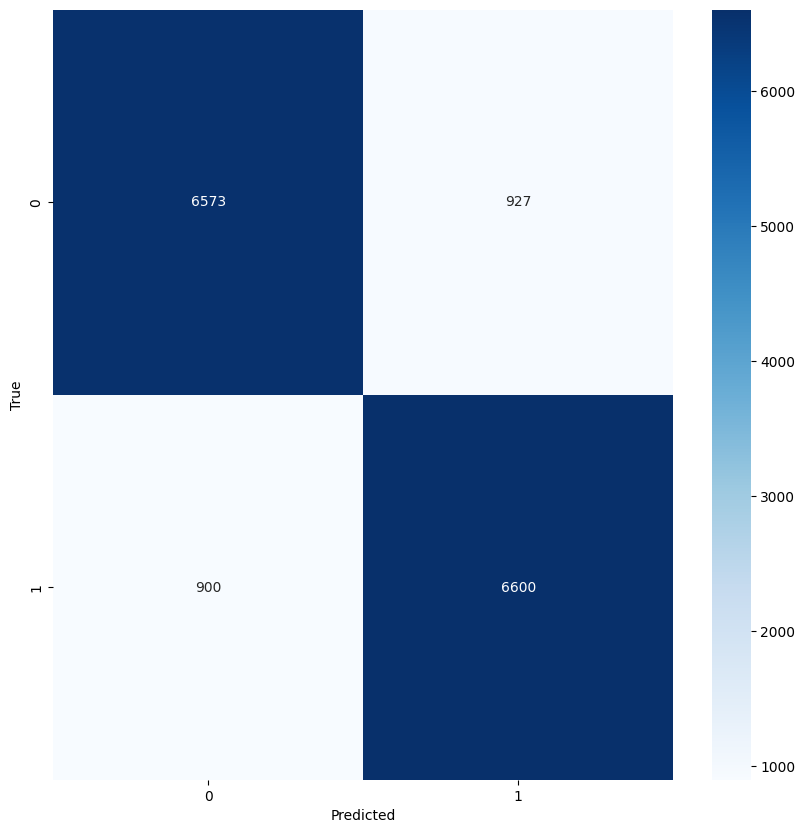

In [34]:
plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')

plt.xlabel('Predicted')
plt.ylabel('True')

##Submission

In [ ]:
df_criticas_test_x = vectorizer.transform(df_criticas_test_copy['review_es'])

In [ ]:
prediction_stacking=stacking_model.predict(df_criticas_test_x)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(['negativo', 'positivo'])
y_pred_stacking = label_encoder.inverse_transform(prediction_stacking)
print(y_pred_stacking)

['negativo' 'negativo' 'negativo' ... 'negativo' 'negativo' 'negativo']


In [ ]:
df_submission = pd.DataFrame({"ID":df_criticas_test_copy['ID'], "sentimiento" : y_pred_stacking.flatten()})
print(df_submission.shape)
print(df_criticas_test_copy.shape)
df_submission.head()

(8599, 2)
(8599, 2)


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo


In [ ]:
df_submission.to_csv("submission_stacking.csv",index=False)